In [ ]:
import pandas as pd
import numpy as np
import os

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from madrigal.evaluate.predict import get_data_for_analysis, make_predictions, get_drug_specific_scores
from madrigal.evaluate.metrics import get_metrics
from madrigal.utils import BASE_DIR
%matplotlib inline

DDI_PATH = BASE_DIR + 'processed_data/polypharmacy_new/DrugBank/'
VIEWS_PATH = BASE_DIR + 'processed_data/views_features_new/'

In [4]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets", "enzymes", "carriers", "transporters"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

# confirm that "best" drug pairs don't have adverse ddi effects with another dataset
db_polypharmacy = pd.read_csv(DDI_PATH + 'drugbank_ddi_directed_final.tsv', index_col=None)[["label_indexed", "drug_index_1", "drug_index_2"]]
db_polypharmacy = pd.concat([
    db_polypharmacy,
    db_polypharmacy.rename(columns={"drug_index_1":"drug_index_2", "drug_index_2":"drug_index_1"})
], axis=0).drop_duplicates()

organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')
organ_class_mapping = organs_csv.set_index("ddi_class").to_dict()["organ"]  # ddi_class : organ


Index(['drugbank_id', 'drug_name', 'drug_type', 'smiles', 'inchikey',
       'description', 'indication', 'pharmacodynamics', 'moa', 'absorption',
       'metabolism', 'toxicity', 'atc_codes', 'classifications', 'targets',
       'enzymes', 'carriers', 'transporters'],
      dtype='object')


In [ ]:
data_source = "DrugBank"
split_method = "split_by_drugs_random"
repeat = None
checkpoint = "major-waterfall-304"  # DrugBank, split_by_drugs_random
epoch = None
kg_encoder = 'hgt'
checkpoint_dir = BASE_DIR + f'model_output/{data_source}/{split_method}/{checkpoint}/'
if epoch is None:
    ckpt = checkpoint_dir + "best_model.pt"
else:
    ckpt = checkpoint_dir + f"checkpoint_{epoch}.pt"
finetune_mode = "str_str+random_sample"

In [9]:
# configs for str ablation
str_ablation_checkpoint = "swift-water-311"  # DrugBank, split-by-drugs-random

kg_encoder = "hgt"
str_ablation_checkpoint_dir = BASE_DIR + f"model_output/{data_source}/{split_method}/{str_ablation_checkpoint}/"
if epoch is None:
    str_ablation_ckpt = str_ablation_checkpoint_dir + "best_model.pt"
else:
    str_ablation_ckpt = str_ablation_checkpoint_dir + f"checkpoint_{epoch}.pt"
str_ablation_finetune_mode = "ablation_str_str"
device = torch.device("cpu")

str_ablation_train_batch, str_ablation_val_batches, str_ablation_test_batches, str_ablation_label_map = get_data_for_analysis(
    data_source=data_source, kg_encoder=kg_encoder, split_method=split_method, repeat=repeat, 
    path_base = BASE_DIR + "processed_data/", checkpoint_dir=str_ablation_checkpoint_dir
)

# test between
str_ablation_batch = str_ablation_test_batches[0]

In [11]:
# configs for no pretraining ablation
no_pretrain_ablation_checkpoint = "frosty-donkey-308"  # DrugBank, split-by-drugs-random

kg_encoder = "hgt"
no_pretrain_ablation_checkpoint_dir = BASE_DIR + f"model_output/{data_source}/{split_method}/{no_pretrain_ablation_checkpoint}/"
if epoch is None:
    no_pretrain_ablation_ckpt = no_pretrain_ablation_checkpoint_dir + "best_model.pt"
else:
    no_pretrain_ablation_ckpt = no_pretrain_ablation_checkpoint_dir + f"checkpoint_{epoch}.pt"
no_pretrain_ablation_finetune_mode = "str_str+random_sample"
device = torch.device("cpu")

no_pretrain_ablation_train_batch, no_pretrain_ablation_val_batches, no_pretrain_ablation_test_batches, no_pretrain_ablation_label_map = get_data_for_analysis(
    data_source=data_source, kg_encoder=kg_encoder, split_method=split_method, repeat=repeat, 
    path_base=BASE_DIR+"processed_data/", checkpoint_dir=no_pretrain_ablation_checkpoint_dir
)

# test between
no_pretrain_ablation_batch = no_pretrain_ablation_test_batches[0]

In [12]:
# test between
train_batch, val_batches, test_batches, label_map = get_data_for_analysis(
    data_source=data_source, kg_encoder=kg_encoder, split_method=split_method, repeat=repeat, 
    path_base=BASE_DIR+"processed_data/", checkpoint_dir=checkpoint_dir
)
batch = test_batches[0]

ddi_labels = batch['edge_indices']['label']
ddi_pos_neg_samples = batch['edge_indices']['pos_neg'].float()
true_ddis = ddi_pos_neg_samples
label_map_valid = np.array(label_map)[np.unique(ddi_labels)]

In [ ]:
# generate scores and label-stratified metrics for full model
eval_type = 'full_full'  # 'str_full', 'str+tx_full', 'str+cv+tx_full'

device = torch.device("cuda")
pred_ddis = make_predictions(ckpt, batch, eval_type, finetune_mode, device)  # expect to see two printings of missing keys, the first one containing "covariates_embeddings.0.weight"

metrics, pos_samples = get_metrics(
    pred_ddis.numpy(), 
    true_ddis.numpy(), 
    ddi_labels.numpy(), 
    k=50, 
    task='multiclass', 
    average=None, 
    logger=None, 
    verbose=False, 
)

test_between_scores = pd.DataFrame({
    "label_ind":np.unique(ddi_labels),
    'label':label_map_valid, 
    'specificity':metrics['specificity'], 
    'npv':metrics['npv'], 
    'auprc':metrics['auprc'], 
    'auroc':metrics['auroc'], 
    'num_pos_sample':pos_samples.astype(int)
}).sort_values('auprc', ascending=False)

In [ ]:
# drug-stratified scores
eval_type = "str_full"

all_metrics, between_test_drugs = get_drug_specific_scores(checkpoint_dir, batch, eval_type, finetune_mode, device, mode="test_between")
str_ablation_all_metrics, between_test_drugs = get_drug_specific_scores(str_ablation_checkpoint_dir, str_ablation_batch, eval_type, str_ablation_finetune_mode, device, mode='test_between')
no_pretrain_ablation_all_metrics, between_test_drugs = get_drug_specific_scores(no_pretrain_ablation_checkpoint_dir, no_pretrain_ablation_batch, eval_type, no_pretrain_ablation_finetune_mode, device, mode='test_between')

In [ ]:
# drug-stratified scores
eval_type = "full_full"

all_metrics_full_full, _ = get_drug_specific_scores(checkpoint_dir, batch, eval_type, finetune_mode, device, mode="test_between")
str_ablation_all_metrics_full_full, _ = get_drug_specific_scores(str_ablation_checkpoint_dir, str_ablation_batch, eval_type, str_ablation_finetune_mode, device, mode='test_between')
no_pretrain_ablation_all_metrics_full_full, _ = get_drug_specific_scores(no_pretrain_ablation_checkpoint_dir, no_pretrain_ablation_batch, eval_type, no_pretrain_ablation_finetune_mode, device, mode='test_between')

# Examine label-wise DDI predictions

Examine best and worst DDIs. It looks like some interesting adverse events such as `renal failure` are predicted well.

In [16]:
num_samples_in_classes = (db_polypharmacy["label_indexed"].value_counts() / 2).astype(int).to_dict()
test_between_scores["organ"] = test_between_scores["label"].apply(lambda ddi_class: organ_class_mapping[ddi_class])
test_between_scores["num_all_pos_sample"] = test_between_scores["label_ind"].apply(lambda ind: num_samples_in_classes[ind])
test_between_scores[test_between_scores['num_pos_sample'] >= 5].head(10)

,label_ind,label,specificity,npv,auprc,auroc,num_pos_sample,organ,num_all_pos_sample
31,34,"cardiac arrhythmia, CNS stimulation, increase",1.000000,1.000000,1.000000,1.000000,5,heart,23
55,58,"gastrointestinal ulceration, gastrointestinal ...",1.000000,1.000000,1.000000,1.000000,14,gastrointestinal,59
139,150,"ulceration, increase",1.000000,1.000000,1.000000,1.000000,14,gastrointestinal,59
137,148,"thrombocytopenia, increase",0.937500,1.000000,1.000000,1.000000,8,blood,37
37,40,"congestive heart failure, hypotension, increase",1.000000,0.909091,1.000000,1.000000,5,heart,35
71,76,"hyponatremia, water intoxication, increase",1.000000,1.000000,1.000000,1.000000,5,kidney,23
32,35,"cardiac arrhythmia, cardiotoxicity, increase",0.983871,1.000000,1.000000,1.000000,31,heart,157
140,151,"urinary retention, increase",1.000000,0.945455,1.000000,1.000000,26,urinary,119
134,145,"tendinopathy, increase",0.983245,0.997317,0.996030,0.998282,567,others/general,1855
66,70,"hyperthermia, oligohydrosis, increase",0.980000,0.942308,0.987203,0.993600,25,others/general,120


In [17]:
test_between_scores[test_between_scores['num_pos_sample'] >= 5].tail(10).iloc[::-1]

,label_ind,label,specificity,npv,auprc,auroc,num_pos_sample,organ,num_all_pos_sample
87,95,"myelosuppression, increase",0.889175,0.688623,0.462493,0.609483,194,blood,418
81,89,"liver damage, increase",0.916107,0.714660,0.522468,0.707130,149,liver,400
124,135,"serotonin, seizure, increase",0.928571,0.722222,0.581746,0.683673,7,others/general,35
107,116,"photosensitizing, increase",0.923077,0.705882,0.583819,0.704142,13,others/general,63
10,12,"alpha-adrenergic, increase",0.928571,0.722222,0.592732,0.561224,7,heart,31
120,130,"seizure, increase",0.975352,0.713918,0.600432,0.723914,142,others/general,337
44,47,"excretion rate, decrease | serum level, increase",0.943374,0.744023,0.602677,0.633027,50551,"liver, kidney",157241
42,45,"effectiveness as a diagnostic agent, decrease",0.940860,0.736842,0.631892,0.719476,186,others/general,684
7,9,"absorption, increase | serum level, increase |...",0.777778,0.800000,0.654862,0.701871,72,others/general,180
126,137,"serum level of the active metabolites, decreas...",0.863636,0.760000,0.655902,0.752066,11,others/general,42


# Examine drug-stratified DDI predictions

## Performance vs max structural similarity with any train drug

In [17]:
metric_name = "auprc"
train_drugs = train_batch['head']['drugs'].tolist()
train_sms = drug_metadata['canonical_smiles'].values[train_drugs]
test_sms = drug_metadata['canonical_smiles'].values[between_test_drugs]

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
between_test_max_sim_scores = []
between_test_highest_5_mean_sim_scores = []

train_mols = [AllChem.AddHs(Chem.MolFromSmiles(sm)) for sm in train_sms]
train_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=256) for x in train_mols]
test_mols = [AllChem.AddHs(Chem.MolFromSmiles(sm)) for sm in test_sms]
test_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=256) for x in test_mols]

# tanimoto similarity
# https://stackoverflow.com/questions/51681659/how-to-use-rdkit-to-calculte-molecular-fingerprint-and-similarity-of-a-list-of-s
# BulkDiceSimilarity, BulkTanimotoSimilarity
for fp in test_fps:
    sims = DataStructs.BulkTanimotoSimilarity(fp, train_fps)  # max similarity
    between_test_max_sim_scores.append(np.max(sims))
    between_test_highest_5_mean_sim_scores.append(np.mean(np.partition(sims, -5)[-5:]))

In [18]:
drug_metadata.loc[between_test_drugs[(np.array(between_test_max_sim_scores) < .25) & (np.array(all_metrics['auprc']) < np.array(str_ablation_all_metrics['auprc']))]][
    ["canonical_smiles", "node_name"] + [col for col in drug_metadata.columns if col.startswith("view_")]
]

,canonical_smiles,node_name,view_tx_mcf7,view_tx_npc,view_tx_hela,view_tx_hec108,view_tx_thp1,view_tx_ha1e,view_tx_ht29,view_tx_hepg2,...,view_tx_hcc515,view_tx_yapc,view_tx_pc3,view_tx_vcap,view_tx_a375,view_tx_asc,view_tx_huvec,view_cv,view_kg,view_str
1315,[Pt],Platinum,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1826,S=[Mo](=S)([S-])[S-],Tetrathiomolybdate,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2077,[Ca+2].[N-]=C=[N-],Calcium carbimide,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3102,[Xe],Xenon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


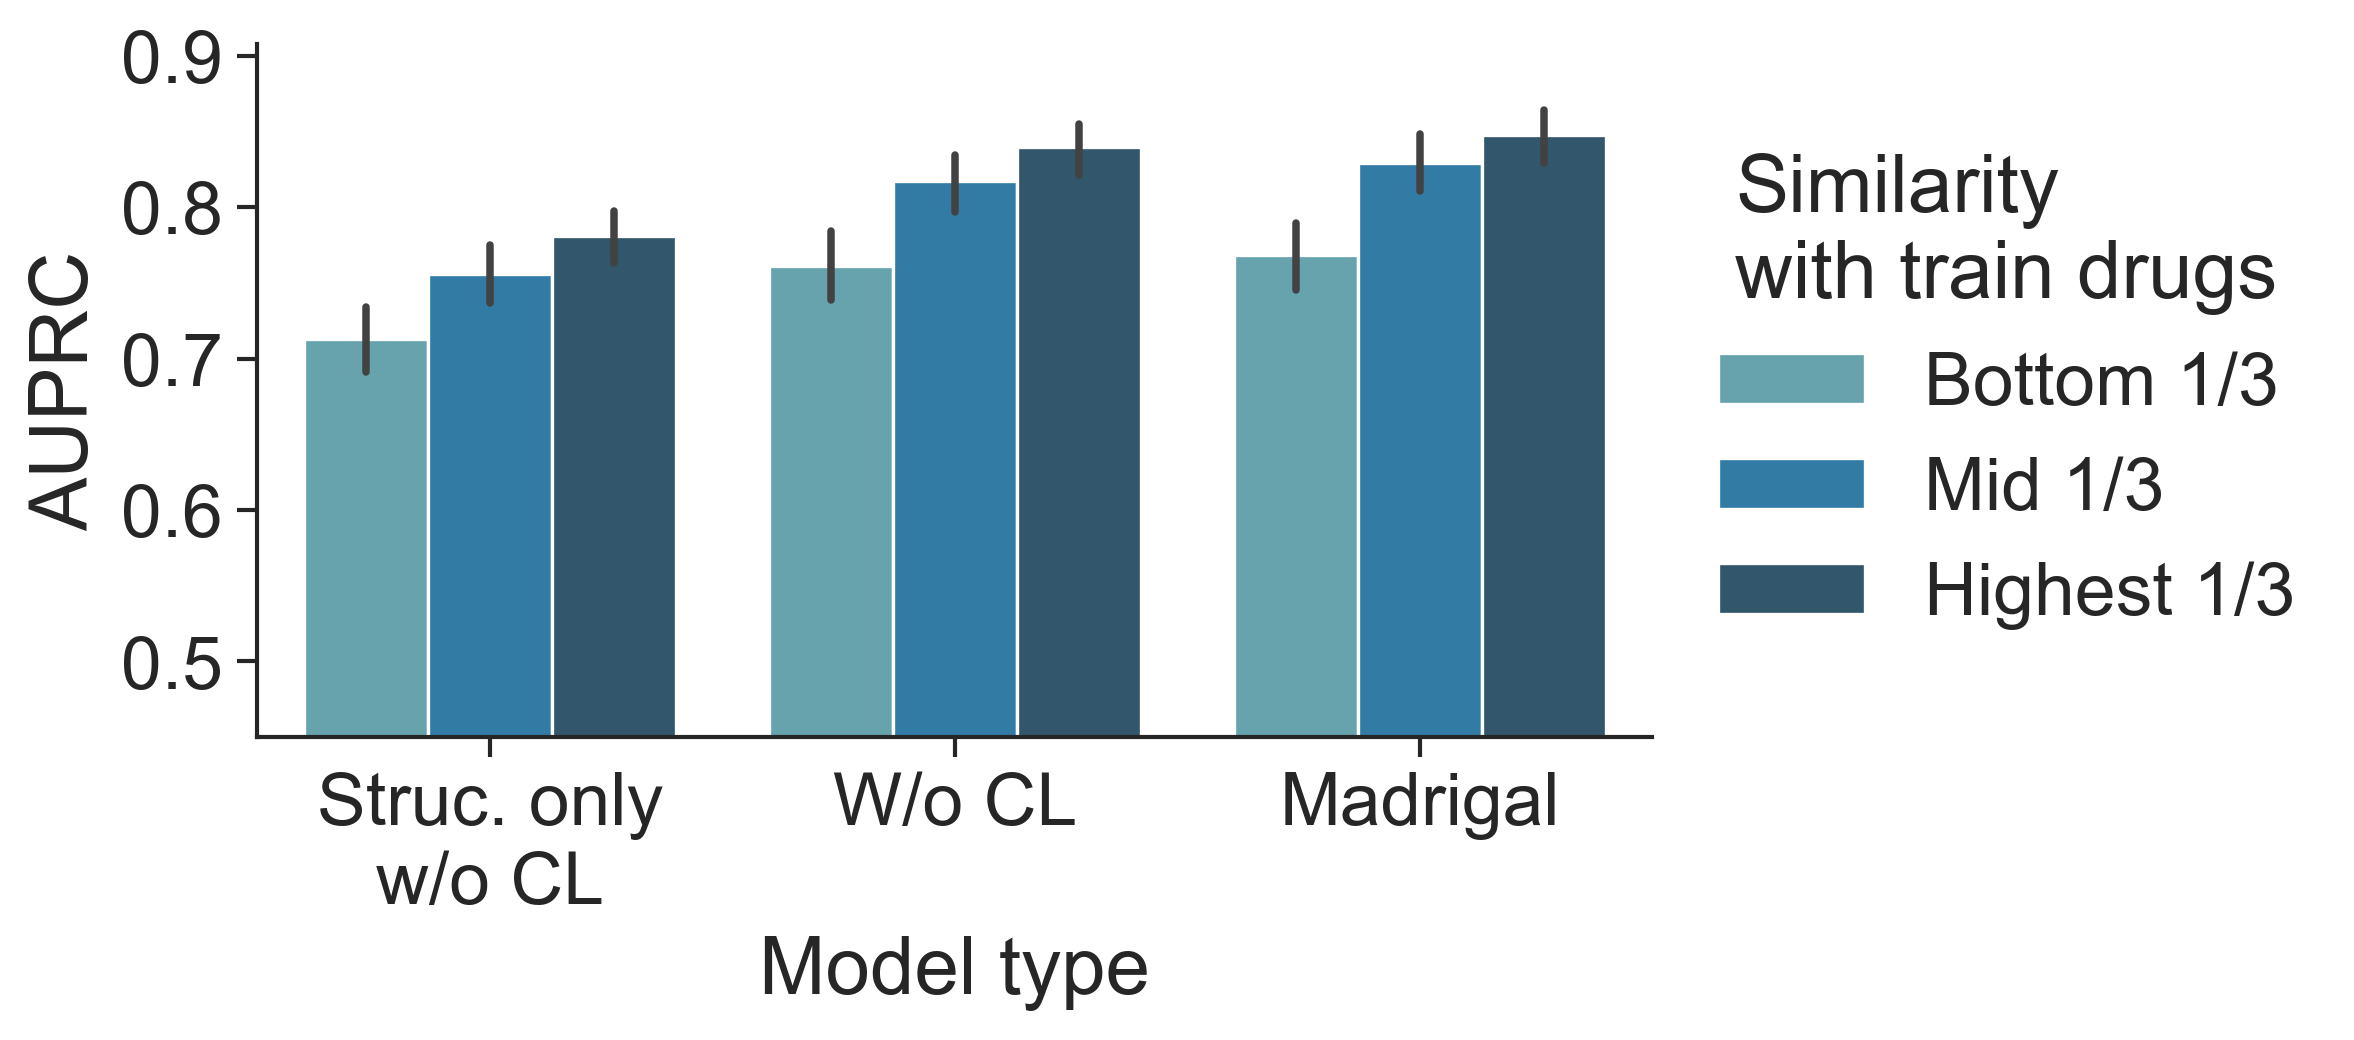

In [37]:

num_bins = 3
sim_groups = np.zeros_like(between_test_highest_5_mean_sim_scores)
sim_group_labels = np.array(["aaaaaaaaa"] * len(between_test_highest_5_mean_sim_scores))  # np string array requires to specify maximum length
for lo, hi in zip(np.linspace(0,1,num_bins+1)[:-1], np.linspace(0,1,num_bins+1)[1:]):
    if lo == 0:
        valid_indices = np.where((np.array(between_test_highest_5_mean_sim_scores) >= lo) & (np.array(between_test_highest_5_mean_sim_scores) <= hi))[0]
    else:
        valid_indices = np.where((np.array(between_test_highest_5_mean_sim_scores) > lo) & (np.array(between_test_highest_5_mean_sim_scores) <= hi))[0]
    sim_groups[valid_indices] = (lo+hi) / 2
    sim_group_labels[valid_indices] = f"{lo:.2f}-{hi:.2f}"
    
plot_data = pd.DataFrame({
    'sim': between_test_highest_5_mean_sim_scores + between_test_highest_5_mean_sim_scores + between_test_highest_5_mean_sim_scores,
    'Similarity': sim_group_labels.tolist() * 3,
    'AUPRC': str_ablation_all_metrics['auprc'] + no_pretrain_ablation_all_metrics["auprc"] + all_metrics['auprc'],
    'Model type': ['Struc. only\nw/o CL'] * len(sim_groups) + ["W/o CL"] * len(sim_groups) + ['Madrigal'] * len(sim_groups),
})

# if group by proportion instead of absolute values
plot_data["Similarity"] = ["Highest 1/3" if bin_id in {2} else ("Bottom 1/3" if bin_id in {0} else "Mid 1/3")
                                    for bin_id in pd.qcut(plot_data["sim"], 3, labels=False).values]
plot_data["Similarity"] = plot_data["Similarity"].astype(
    pd.api.types.CategoricalDtype(categories=["Bottom 1/3", "Mid 1/3", "Highest 1/3"], ordered=True)
)

from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(6, 3), dpi=300)
sns.set(style="ticks", font_scale=2, context="paper")

sns.barplot(
    plot_data, hue='Similarity', y='AUPRC', x='Model type', palette="YlGnBu_d",
    # capsize=.2, errorbar="se",
    # kind="point", height=6, aspect=.75,
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title="Similarity\nwith train drugs")  # highest 5 mean
plt.ylim(0.45)
plt.yticks(np.arange(0.5, 1.0, 0.1))
sns.despine()

plt.savefig("./fig2_test_highest_5_mean_str_sim_with_train.svg", format="svg", dpi=300)
plt.show()

In [26]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "Struc. only\nw/o CL") & (plot_data["Similarity"] == "Bottom 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "Struc. only\nw/o CL") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    alternative="two-sided",
))
print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "Struc. only\nw/o CL") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "Struc. only\nw/o CL") & (plot_data["Similarity"] == "Highest 1/3")]["AUPRC"].values,
    alternative="two-sided",
))
print()
print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "W/o CL") & (plot_data["Similarity"] == "Bottom 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "W/o CL") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    alternative="two-sided",
))
print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "W/o CL") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "W/o CL") & (plot_data["Similarity"] == "Highest 1/3")]["AUPRC"].values,
    alternative="two-sided",
))
print()
print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "Madrigal") & (plot_data["Similarity"] == "Bottom 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "Madrigal") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    alternative="two-sided",
))
print(mannwhitneyu(
    plot_data[(plot_data["Model type"] == "Madrigal") & (plot_data["Similarity"] == "Mid 1/3")]["AUPRC"].values,
    plot_data[(plot_data["Model type"] == "Madrigal") & (plot_data["Similarity"] == "Highest 1/3")]["AUPRC"].values,
    alternative="two-sided",
))

MannwhitneyuResult(statistic=24316.5, pvalue=0.0012500909314059662)
MannwhitneyuResult(statistic=26444.5, pvalue=0.07658516684585172)

MannwhitneyuResult(statistic=24119.5, pvalue=0.0007929118580182978)
MannwhitneyuResult(statistic=26850.0, pvalue=0.13194804588707176)

MannwhitneyuResult(statistic=23611.5, pvalue=0.00022830263879445128)
MannwhitneyuResult(statistic=26344.0, pvalue=0.06630170472502173)


## Performance vs target profile similarity with any train drug

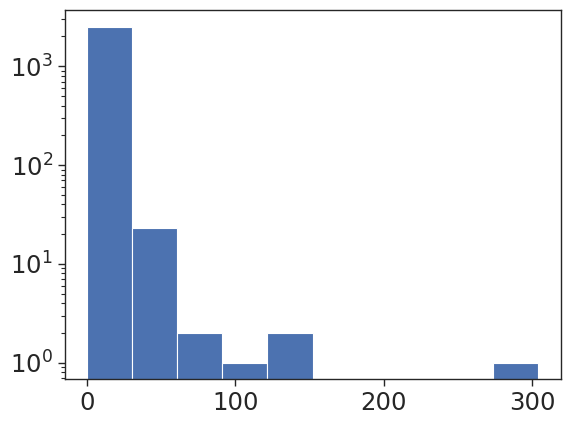

In [27]:
metric_name = "auprc"
train_targets = drug_metadata["targets"].values[train_drugs]
between_test_targets = drug_metadata["targets"].values[between_test_drugs]

plt.hist(list(map(len, train_targets)), ec="white")
plt.yscale("log")

In [28]:
# remove drugs that have too many targets
to_remove_train_ind = [drug_ind for drug_ind, targets in zip(train_drugs, train_targets) if len(targets) > 100]
to_remove_test_ind = [drug_ind for drug_ind, targets in zip(between_test_drugs.tolist(), between_test_targets) if len(targets) > 100]

between_test_target_sim_scores = []

# jaccard similarity
for targets_1 in between_test_targets:
    sims = []
    if len(targets_1) == 0:
        between_test_target_sim_scores.append(sims)
        continue
    for targets_2 in train_targets:
        if len(targets_2) == 0:
            continue
        else:
            sims.append(len(set(targets_1) & set(targets_2)) / len(set(targets_1) | set(targets_2)))
    between_test_target_sim_scores.append(sims)

In [29]:
between_test_target_sims_max = np.array([np.max(sims) if len(sims) > 0 else np.nan for sims in between_test_target_sim_scores])
between_test_target_sims_highest_5_mean = np.array([np.mean(np.partition(sims, -5)[-5:]) if len(sims) > 0 else np.nan for sims in between_test_target_sim_scores])
between_test_target_sims_prop_geq_05 = np.array([(np.array(sims) >= 0.5).sum() / len(sims) if len(sims) > 0 else np.nan for sims in between_test_target_sim_scores])

/tmp/ipykernel_2040839/4063382435.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  ax = sns.pointplot(


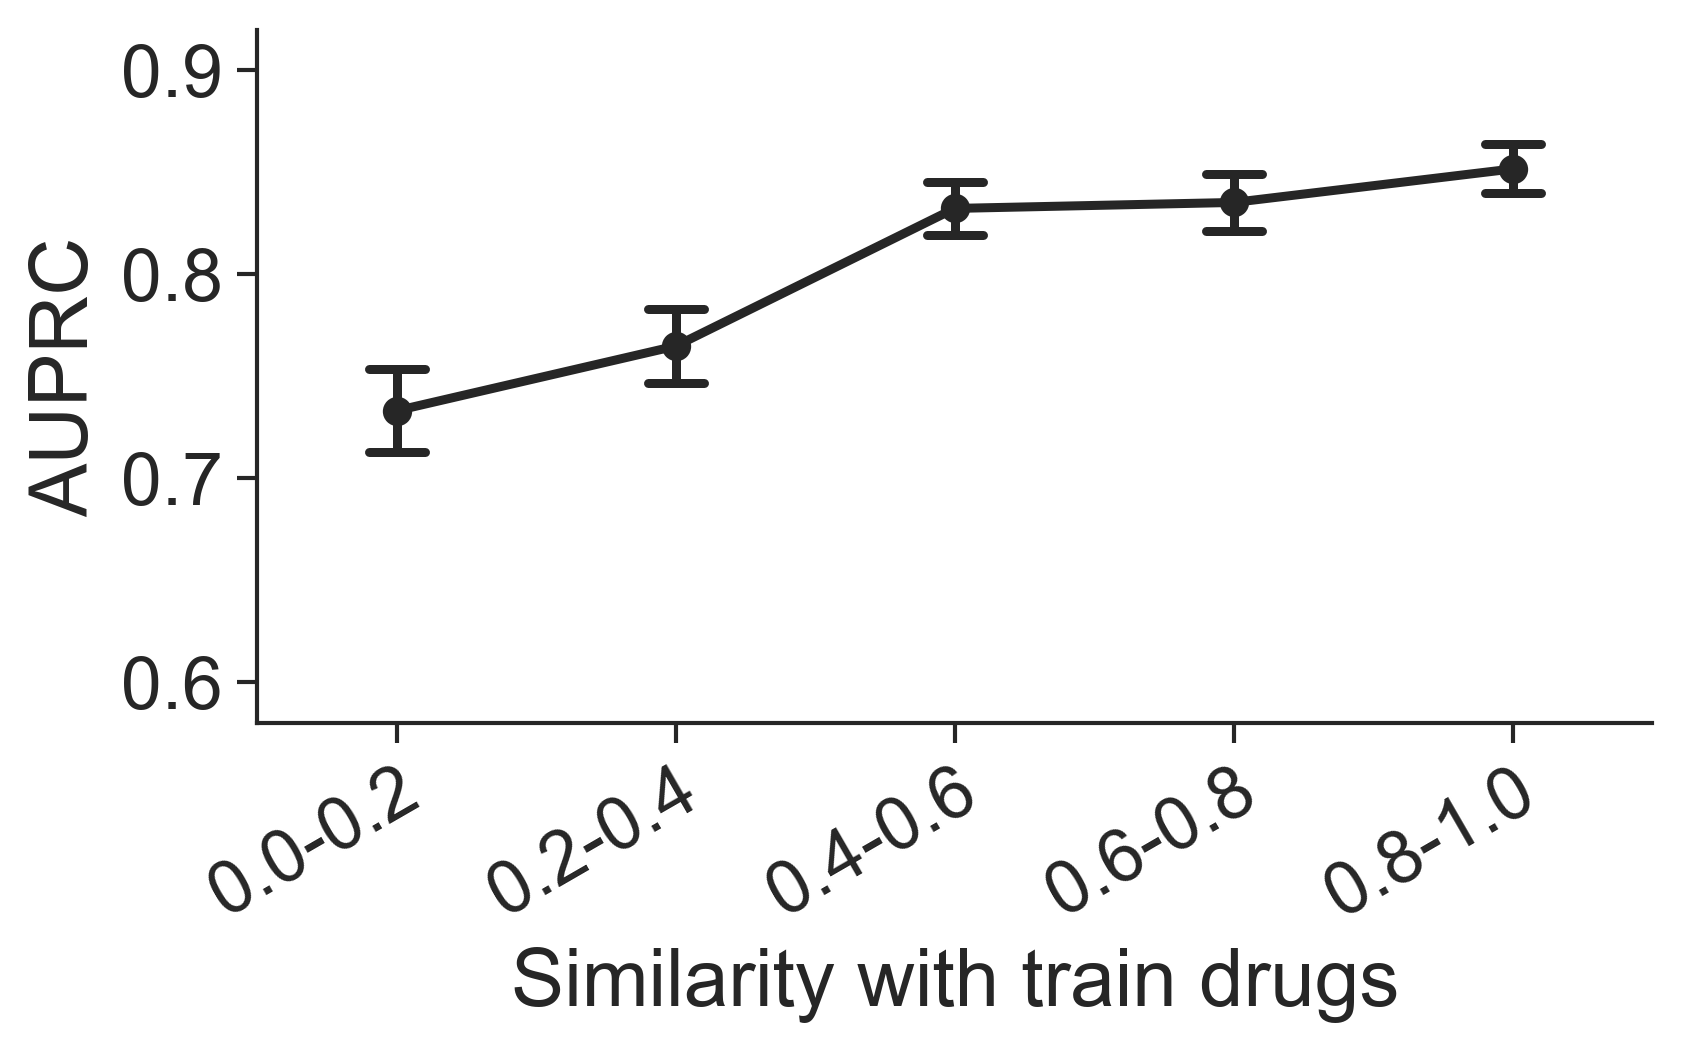

In [38]:
num_bins = 5
median_scores = []
sim_groups = np.zeros_like(between_test_target_sims_highest_5_mean)
sim_group_labels = np.array(["aaaaaaaaa"] * len(between_test_target_sims_highest_5_mean))  # np string array requires to specify maximum length
for lo, hi in zip(np.linspace(0, 1, num_bins+1)[:-1], np.linspace(0, 1, num_bins+1)[1:]):
    if lo == 0:
        valid_indices = np.where((np.array(between_test_target_sims_highest_5_mean) >= lo) & (np.array(between_test_target_sims_highest_5_mean) <= hi))[0]
    else:
        valid_indices = np.where((np.array(between_test_target_sims_highest_5_mean) > lo) & (np.array(between_test_target_sims_highest_5_mean) <= hi))[0]
    sim_groups[valid_indices] = (lo+hi) / 2
    sim_group_labels[valid_indices] = f"{lo:.1f}-{hi:.1f}"
    
plot_data = pd.DataFrame({
    'sim': between_test_target_sims_highest_5_mean.tolist() + between_test_target_sims_highest_5_mean.tolist(),
    'similarity_group': sim_group_labels.tolist() * 2,
    'auprc': all_metrics['auprc'] + str_ablation_all_metrics['auprc'],
    'type': ['full'] * len(sim_groups) + ['structure-only'] * len(sim_groups)
})
plot_data = plot_data[~plot_data["sim"].isna()]

plt.figure(figsize=(6, 3), dpi=300)
sns.set(style="ticks", font_scale=2, context="paper")

ax = sns.pointplot(
    plot_data[plot_data["type"] == "full"], x='similarity_group', y='auprc', hue='type', c="cornflowerblue",
    capsize=.2, errorbar="se", order=sorted(plot_data["similarity_group"].unique()), 
    color="black", 
)
ax.get_legend().remove()
plt.ylabel("AUPRC")
# plt.xlabel("Average of highest 5\nJaccard similarity with train drugs")
plt.xlabel("Similarity with train drugs")
plt.ylim(0.58, 0.92)
plt.yticks(np.arange(0.6, 0.9, 0.1))
sns.despine()
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")

plt.savefig("./fig2_test_highest_5_mean_target_sim_with_train.svg", format="svg", dpi=300)
plt.show()

In [35]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.0-0.2")]["auprc"].values,
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.2-0.4")]["auprc"].values
))
print(mannwhitneyu(
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.2-0.4")]["auprc"].values,
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.4-0.6")]["auprc"].values
))
print(mannwhitneyu(
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.4-0.6")]["auprc"].values,
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.6-0.8")]["auprc"].values,
))
print(mannwhitneyu(
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.6-0.8")]["auprc"].values,
    plot_data[(plot_data["type"] == "full") & (plot_data["similarity_group"] == "0.8-1.0")]["auprc"].values
))

MannwhitneyuResult(statistic=2652.0, pvalue=0.20271483585888916)
MannwhitneyuResult(statistic=2389.0, pvalue=0.009582276961657617)
MannwhitneyuResult(statistic=2496.0, pvalue=0.8132458686494045)
MannwhitneyuResult(statistic=3476.5, pvalue=0.1012277151906895)
